In [1]:
from IPython.core.magic import register_cell_magic
import importlib

@register_cell_magic
def spark_class(line, cell):
    module = line.strip()
    f = "{0}.py".format(module)

    with open(f, "w") as fw:
        fw.write(cell)

    globals()[module] = importlib.import_module(module)
    sc.addPyFile(f)

In [2]:
%%spark_class session
class Session:
    def __init__(self, IP, sessionNumUrls,sessionLengthInMinutes):
        self.IP = IP
        self.sessionNumUrls = sessionNumUrls
        self.sessionLengthInMinutes = sessionLengthInMinutes

In [3]:
rdd = sc.textFile('data/2015_07_22_mktplace_shop_web_log_sample.log')
rdd = rdd.map(lambda x: x.split(" "))

In [4]:
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
import dateutil.parser

#sort data by IP address then timestamp
rdd_sorted = rdd.map(lambda x: (x[2].split(':')[0],Row(timestamp=dateutil.parser.parse(x[0]),url=x[12])))

In [27]:
grouped = rdd_sorted.map(lambda x:(x[0],[x[1]])).reduceByKey(lambda p,q: p+q)

In [30]:
#group data by IP, group:RDD[(IP, [rows])]
grouped_sorted = grouped.map(lambda x:(x[0],sorted(x[1],key=lambda row:row.timestamp)))

In [31]:
grouped_sorted.take(5)

[('117.198.215.20',
  [Row(timestamp=datetime.datetime(2015, 7, 22, 9, 0, 28, 57527, tzinfo=tzutc()), url='https://paytm.com:443/blog/wp-content/themes/svbtle/style.css'),
   Row(timestamp=datetime.datetime(2015, 7, 22, 9, 0, 29, 46982, tzinfo=tzutc()), url='https://paytm.com:443/blog/wp-content/plugins/jetpack/css/jetpack.css?ver=3.5.3')]),
 ('182.66.58.248',
  [Row(timestamp=datetime.datetime(2015, 7, 22, 9, 0, 28, 62804, tzinfo=tzutc()), url='https://paytm.com:443/shop/action'),
   Row(timestamp=datetime.datetime(2015, 7, 22, 9, 3, 23, 302978, tzinfo=tzutc()), url='https://paytm.com:443/shop/wallet/balance'),
   Row(timestamp=datetime.datetime(2015, 7, 22, 9, 3, 23, 332664, tzinfo=tzutc()), url='https://paytm.com:443/shop/user/address'),
   Row(timestamp=datetime.datetime(2015, 7, 22, 9, 3, 24, 851943, tzinfo=tzutc()), url='https://paytm.com:443/shop/logout'),
   Row(timestamp=datetime.datetime(2015, 7, 22, 9, 3, 25, 92509, tzinfo=tzutc()), url='https://paytm.com:443/shop'),
   Row(

In [32]:
#group timestamps and url within 15 mins into sessions
def Sessionize(x):
    ip_addr = x[0]
    visit_list = x[1]
    size = len(visit_list)
    sessionUrls = [set([visit_list[0].url])] #store unique urls for each session
    sessions = [[visit_list[0].timestamp]] #timestamps of each session
    sessionLengthInMinutes = [] #length of each session
    sessionNumUrls = [] #number of unique urls
    
    for i in range(1,size,1):
        if (visit_list[i].timestamp - sessions[-1][-1]).total_seconds()/60 <= 15: #two timestamps in same session
            sessions[-1].append(visit_list[i].timestamp)
            sessionUrls[-1].add(visit_list[i].url)
        else:
            sessions.append([visit_list[i].timestamp]) #start a new session
            sessionUrls.append(set([visit_list[i].url]))

    for sess in sessions:
        sessionLengthInMinutes.append((sess[-1]-sess[0]).total_seconds()/60)
    
    for sessionUrl in sessionUrls:
        sessionNumUrls.append(len(sessionUrl))
    
    return session.Session(ip_addr, sessionNumUrls, sessionLengthInMinutes)

In [33]:
#create sessions for each each IP address
grouped_sessionized = grouped_sorted.map(lambda x:Sessionize(x))
grouped_sessionized.cache()

PythonRDD[42] at RDD at PythonRDD.scala:52

In [34]:
#get number of unique urls and length of sessions for each IP, sorted by number of sessions
grouped_sessionized.map(lambda x:(x.IP, x.sessionNumUrls, x.sessionLengthInMinutes)).sortBy(lambda x:len(x[2]),ascending=False).take(5)

[('220.226.206.7',
  [7, 5, 25, 13, 42, 15, 61, 105, 50, 92, 284, 30, 163],
  [3.0329445333333336,
   3.0448327333333336,
   4.056144683333334,
   4.024646466666667,
   34.0800585,
   4.8486105833333335,
   4.8596510833333335,
   4.173275283333333,
   13.028803033333332,
   4.2956905,
   25.08101915,
   4.992088083333333,
   3.7483676833333335]),
 ('54.251.151.39',
  [3, 3, 3, 4, 7, 3, 3, 4, 3, 2],
  [4.946743883333334,
   4.976086116666666,
   4.996719733333333,
   4.213974966666666,
   34.45038280000001,
   14.581265116666666,
   4.317303016666667,
   4.9391726333333335,
   4.982523366666666,
   4.875647783333333]),
 ('119.81.61.166',
  [3334, 1100, 1671, 489, 1739, 8016, 2786, 3928, 3637, 2841],
  [4.950189583333333,
   4.9740852166666665,
   4.986045,
   4.2217356,
   34.4808075,
   14.613619533333333,
   4.337334383333333,
   4.9999253333333336,
   4.986084966666667,
   4.993532816666667]),
 ('54.250.253.236',
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [4.07740025,
   1.5254125,
   4.575

In [35]:
#use average to predict the session length of given url
import numpy as np
session_length_pred = grouped_sessionized.map(lambda x:(x.IP,np.mean(x.sessionLengthInMinutes)))

In [36]:
#get top 10 active users, ranked by average session length
session_length_pred.sortBy(lambda x:x[1],ascending=False).take(10)

[('103.29.159.138', 34.42355186666667),
 ('125.16.218.194', 34.407923399999994),
 ('14.99.226.79', 34.381827933333334),
 ('122.169.141.4', 34.3359822),
 ('14.139.220.98', 34.305317716666664),
 ('117.205.158.11', 34.287053066666665),
 ('111.93.89.14', 34.249600699999995),
 ('182.71.63.42', 34.17429933333334),
 ('223.176.3.130', 34.128679416666664),
 ('183.82.103.131', 34.045396966666665)]

In [37]:
totalSession, totalSessionLength = grouped_sessionized.map(lambda x:(len(x.sessionLengthInMinutes),np.sum(x.sessionLengthInMinutes))).reduce(lambda x1,x2:(x1[0]+x2[0],x1[1]+x2[1]))

In [38]:
totalSessionLength / totalSession #overall average session length

1.6787918246979088

In [39]:
totalSession, totalSessionUrls = grouped_sessionized.map(lambda x:(len(x.sessionNumUrls),np.sum(x.sessionNumUrls))).reduce(lambda x1,x2:(x1[0]+x2[0],x1[1]+x2[1]))

In [40]:
totalSessionUrls / float(totalSession) #overall number of unique urls per session

8.314305563074036

In [41]:
#use average to predict number of unique urls of a given IP per session
session_url_pred = grouped_sessionized.map(lambda x:(x.IP,np.mean(x.sessionNumUrls)))

In [42]:
session_url_pred.sortBy(lambda x:x[1],ascending=False).take(10)

[('52.74.219.71', 3211.9),
 ('119.81.61.166', 2954.1),
 ('106.51.132.54', 2609.0),
 ('106.186.23.95', 1375.8),
 ('54.169.0.163', 859.3333333333334),
 ('54.169.64.74', 825.0),
 ('54.169.20.106', 779.2857142857143),
 ('54.169.79.96', 747.3333333333334),
 ('54.169.164.205', 735.5714285714286),
 ('54.251.128.29', 702.5)]

In [17]:
###########################################################
## Part 2
###########################################################
rdd = sc.textFile('data/2015_07_22_mktplace_shop_web_log_sample.log')
rdd = rdd.map(lambda line: line.split(" "))
logDF = rdd.map(lambda line: Row(timestamp=line[0], ipaddress=line[2].split(':')[0],url=line[12])).toDF()


In [18]:
logDF.show(20)

+---------------+--------------------+--------------------+
|      ipaddress|           timestamp|                 url|
+---------------+--------------------+--------------------+
|123.242.248.130|2015-07-22T09:00:...|https://paytm.com...|
|  203.91.211.44|2015-07-22T09:00:...|https://paytm.com...|
|    1.39.32.179|2015-07-22T09:00:...|https://paytm.com...|
| 180.179.213.94|2015-07-22T09:00:...|https://paytm.com...|
| 120.59.192.208|2015-07-22T09:00:...|https://paytm.com...|
| 117.239.195.66|2015-07-22T09:00:...|https://paytm.com...|
|  101.60.186.26|2015-07-22T09:00:...|https://paytm.com...|
|   59.183.41.47|2015-07-22T09:00:...|https://paytm.com...|
| 117.239.195.66|2015-07-22T09:00:...|https://paytm.com...|
|  183.83.237.83|2015-07-22T09:00:...|https://paytm.com...|
|  117.195.91.36|2015-07-22T09:00:...|https://paytm.com...|
|122.180.245.251|2015-07-22T09:00:...|https://paytm.com...|
| 117.198.215.20|2015-07-22T09:00:...|https://paytm.com...|
| 223.176.154.91|2015-07-22T09:00:...|ht

In [19]:
logDF = logDF.withColumn('timestamp', logDF['timestamp'].cast(TimestampType()))
loadperMinDF = logDF.select(window("timestamp", "60 seconds").alias('timewindow'),'timestamp',"ipaddress").groupBy('timewindow').count().withColumnRenamed('count', 'HitperMin')

In [20]:
loadperMinPandasDf = loadperMinDF.sort("timewindow.start").toPandas()

In [21]:
loadperMinPandasDf.index = [s[0] for s in loadperMinPandasDf['timewindow']]
loadperMinPandasDf.drop(['timewindow'],1,inplace=True)
loadperMinFilled = loadperMinPandasDf.asfreq('min').fillna(0)

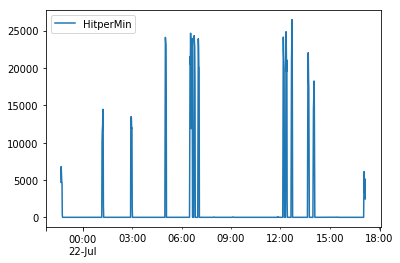

In [23]:
#plot hits per minute
import matplotlib.pyplot as plt 
loadperMinFilled.plot()
plt.show()

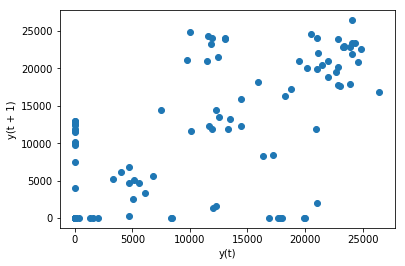

In [24]:
#plot y(t) vs y(t+1)
from pandas.plotting import lag_plot
lag_plot(loadperMinFilled)
plt.show()

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(loadperMinFilled)

In [ ]:
#plot y(t) - y(t-1)
loadperMinFilled['HitperMin'].diff().dropna().plot()

In [ ]:
#taking sqrt transformation then differencing, try to make the time series stationary in order to use AR or MA model

import numpy as np
loadperMinFilled['#HitperMin_sqrt'] = np.sqrt(loadperMinFilled['HitperMin'])
loadperMinFilled['#HitperMin_sqrt_diff'] = loadperMinFilled['#HitperMin_sqrt'].diff()
loadperMinFilled['#HitperMin_sqrt_diff'].dropna().plot()
plt.show()

In [ ]:
#the time series is not stationary after transformation and differencing, use y(t-1) to predict y(t)
y_next_pred = loadperMinFilled['HitperMin'][1:]/60

In [ ]:
y_next_pred